<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D1%83%D0%B5%D0%BC_%D0%BD%D0%B0_%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8(LogisticRegressionCV)_%D0%B7%D0%BD%D0%B0%D0%BA_%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогнозируем на логистической регрессии(LogisticRegressionCV) знак относительных изменений абсолютных валютных курсов**

**Абсолютный курс**

Енин А.В.

г. Оренбург

2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

Прогнозируем знак относительных изменений абсолютного курса. Для этого применяем модель логистической регрессии (LogisticRegressionCV) по предыдущим значениям (с некоторым окном) относительных изменений абсолютного курса.

# Библиотеки

In [84]:
import datetime
print('[{}]'.format(datetime.date.today()))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *

[2020-04-08]


# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [85]:
data_url = 'https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/export?format=csv&id=1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs&gid=422799220'
abs_data = pd.read_csv(data_url,decimal=',',parse_dates=True,index_col=0)
abs_data.shape

(1313, 45)

# Подготовка данных

Вычисляем матрицу относительных изменений абсолютных валютных курсов

In [0]:
dates = abs_data.index.values # даты
cur_names = abs_data.columns.values # имена валют
data = abs_data.values # матрица абсолютных курсов
d_data = np.zeros_like(data) # матрица относительных изменений
d_data[1:,:] = (data[1:,:]-data[:-1,:])/data[:-1,:] # расчет матрицы относительных изменений

# Готовим входы и выходы модели

Нормируем относительные изменения.
Сибираем матрицу входов и выходов для модели прогнозирования.

In [0]:
window = 50 # окно для входов

y = d_data.copy()

y = (y - y.mean(axis=0)) / y.std(axis=0) # нормируем

x_ = [0]*window

for w in range(window):
    x_[w] = np.zeros_like(y)
    x_[w][(1+w):,:] = y[:(-1-w),:]

X = np.concatenate(x_,axis=1)[window:,:]
y = y[window:]
y = np.array(y >= 0,dtype=float) # бинаризируем

In [112]:
X.shape,y.shape

((1263, 2250), (1263, 45))

# Учим классификатор в одной модели для всех валют

Используем стандартный пакет **scikit-learn**

**LogisticRegressionCV классификатор:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html?highlight=logistic#sklearn.linear_model.LogisticRegressionCV

Будем искать модели дающие максимум нормы **balanced_accuracy_score**. Эта норма дает лучшее качество на разбалансированных рядах. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score


In [113]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)
                                # разделяем выборки обучающую и тестовую

preds_train = np.zeros_like(y_train)
preds_test = np.zeros_like(y_test)

for k in range(y.shape[1]):
    cl = LogisticRegressionCV(Cs=20,n_jobs=-1,penalty='l2',solver='lbfgs',scoring=make_scorer(balanced_accuracy_score),cv=TimeSeriesSplit())
    cl.fit(X_train,y_train[:,k])        # учим
    preds_train[:,k] = cl.predict(X_train)   # результат на обучающей выборке
    preds_test[:,k] = cl.predict(X_test)     # результат на тестовой выборке
    print(k,cur_names[k],'best_C={}'.format(cl.C_),
          'f1(train)={:.5}'.format(f1_score(y_train[:,k],preds_train[:,k])),'f1(test)={:.5}'.format(f1_score(y_test[:,k],preds_test[:,k])),
          'b_a_s(train)={:.5}'.format(balanced_accuracy_score(y_train[:,k],preds_train[:,k])),'b_a_s(test)={:.5}'.format(balanced_accuracy_score(y_test[:,k],preds_test[:,k])))
    
    

0 aud best_C=[0.00026367] f1(train)=0.83711 f1(test)=0.49693 b_a_s(train)=0.84046 b_a_s(test)=0.48212
1 cad best_C=[0.00069519] f1(train)=0.88813 f1(test)=0.4669 b_a_s(train)=0.89495 b_a_s(test)=0.51925
2 hkd best_C=[0.00069519] f1(train)=0.71453 f1(test)=0.12717 b_a_s(train)=0.77714 b_a_s(test)=0.51102
3 jpy best_C=[0.0001] f1(train)=0.26501 f1(test)=0.0 b_a_s(train)=0.57637 b_a_s(test)=0.49706
4 sek best_C=[0.0001] f1(train)=0.1886 f1(test)=0.024845 b_a_s(train)=0.55125 b_a_s(test)=0.50316
5 usd best_C=[0.00183298] f1(train)=0.91014 f1(test)=0.20942 b_a_s(train)=0.91856 b_a_s(test)=0.50562
6 chf best_C=[1438.44988829] f1(train)=1.0 f1(test)=0.45756 b_a_s(train)=1.0 b_a_s(test)=0.52703
7 eur best_C=[3792.69019073] f1(train)=1.0 f1(test)=0.44776 b_a_s(train)=1.0 b_a_s(test)=0.52091
8 cny best_C=[0.00183298] f1(train)=0.93967 f1(test)=0.33184 b_a_s(train)=0.94537 b_a_s(test)=0.5149
9 czk best_C=[0.03359818] f1(train)=1.0 f1(test)=0.45185 b_a_s(train)=1.0 b_a_s(test)=0.52405
10 gbp best_

In [114]:
cl.Cs_

array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])

# Метрики на всех

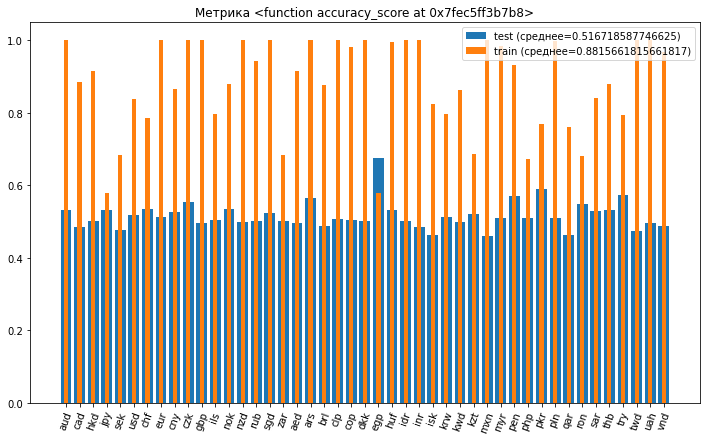

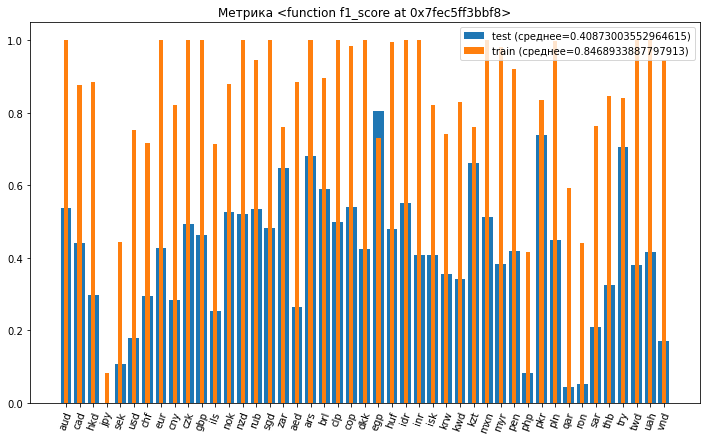

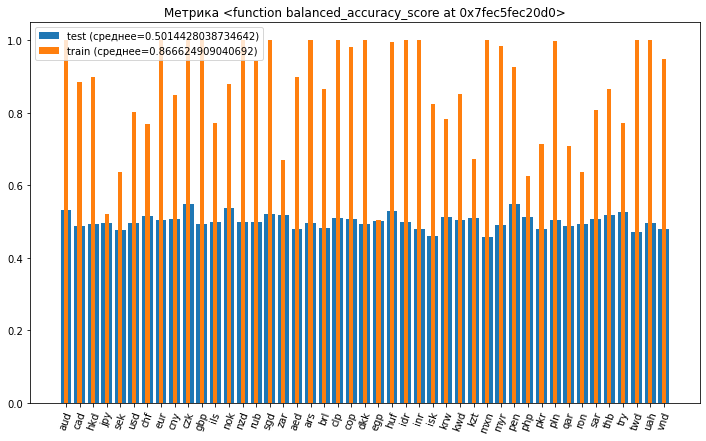

In [110]:
def my_metric(metric_func):
    train_ = [metric_func(y_train[:,k],preds_train[:,k]) for k in range(y.shape[1])]
    test_ = [metric_func(y_test[:,k],preds_test[:,k]) for k in range(y.shape[1])]

    plt.figure(figsize=(12,7))
    plt.bar(cur_names,test_,label="test (среднее={})".format(np.mean(test_)))
    plt.bar(cur_names,train_,width=0.3,label="train (среднее={})".format(np.mean(train_)))
    plt.xticks(rotation=70)
    plt.legend()
    plt.title("Метрика {}".format(metric_func))
    plt.show()

my_metric(accuracy_score)
my_metric(f1_score)
my_metric(balanced_accuracy_score)


По норме balanced_accuracy_score слабые результаты. 